# Kaggle: Plant Pathology 2021 - FGVC8

## Setup environment 

- connect the gDrive with dataset
- extract data to local
- install pytorch lightning

In [1]:
from google.colab import drive
# connect to  my gDrive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# copy the dataset to local drive
! rsync -ah --progress /content/gdrive/Shareddrives/Datasets/plant-pathology-2021-fgvc8_640.zip plant-pathology-2021-fgvc8.zip

sending incremental file list
plant-pathology-2021-fgvc8_640.zip
        683.08M 100%  131.31MB/s    0:00:04 (xfr#1, to-chk=0/1)


In [3]:
# extract dataset to the drive
! unzip plant-pathology-2021-fgvc8.zip | awk 'BEGIN {ORS=" "} {if(NR%250==0)print "."}'
! ls -l

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . total 668436
drwx------ 6 root root      4096 Apr  4 07:43 gdrive
-rw------- 1 root root 683082495 Apr  3 08:45 plant-pathology-2021-fgvc8.zip
drwxr-xr-x 1 root root      4096 Mar 25 13:38 sample_data
-rw-r--r-- 1 root root       100 Mar 11 21:00 sample_submission.csv
drwxr-xr-x 2 root root      4096 Apr  3 08:02 test_images
-rw-r--r-- 1 root root    608503 Mar 11 21:00 train.csv
drwxr-xr-x 2 root root    761856 Apr  3 08:06 train_images


In [4]:
! pip install -q pytorch-lightning torchmetrics
#! pip install -q kaggle_plant-pathology-main.zip
! pip install -q https://github.com/Borda/kaggle_plant-pathology/archive/main.zip

# import os
# os.kill(os.getpid(), 9)
! pip list | grep torch
! pip list | grep kaggle

pytorch-lightning             1.2.6         
torch                         1.8.1+cu101   
torchmetrics                  0.2.0         
torchsummary                  1.5.1         
torchtext                     0.9.1         
torchvision                   0.9.1+cu101   
kaggle                        1.5.12        
kaggle-plant-pathology        0.1.0         


In [5]:
! nvidia-smi

Sun Apr  4 07:44:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data exploration

Checking what data do we have available and what is the labels distribution...

In [6]:
# ! apt-get install -qq -y imagemagick
# #! mogrify -resize 960 train_images/*.jpg

Looking in the training dataset table, what colums and what is the data representation...

In [7]:
%matplotlib inline

import os
import json
import pandas as pd
from pprint import pprint

base_path = '/content'
path_csv = os.path.join(base_path, 'train.csv')
train_data = pd.read_csv(path_csv)
print(train_data.head())

                  image                           labels
0  800113bb65efe69e.jpg                          healthy
1  8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex
2  80070f7fb5e2ccaa.jpg                             scab
3  80077517781fb94f.jpg                             scab
4  800cbf0ff87721f8.jpg                          complex


We can see that each image can have multiple labels so lets check what is the mos common label count...

*The target classes, a space delimited list of all diseases found in the image.
Unhealthy leaves with too many diseases to classify visually will have the complex class, and may also have a subset of the diseases identified.*

In [8]:
import numpy as np

train_data['nb_classes'] = [len(lbs.split(" ")) for lbs in train_data['labels']]
lb_hist = dict(zip(range(10), np.bincount(train_data['nb_classes'])))
pprint(lb_hist)

{0: 0, 1: 17277, 2: 1155, 3: 200}


Browse the label distribution, enrolling all labels in the dataset, so in case an image has two labels both are used in this stat...

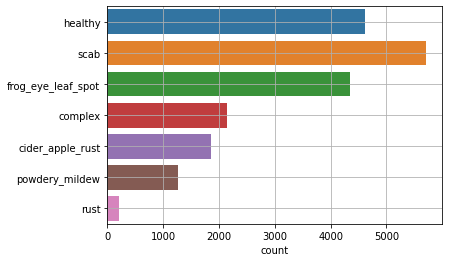

In [ ]:
import itertools
import seaborn as sns

labels_all = list(itertools.chain(*[lbs.split(" ") for lbs in train_data['labels']]))

ax = sns.countplot(y=labels_all, orient='v')
ax.grid()

Get some stat for labels combinations...

In [10]:
labels_unique = set(labels_all)
print(f"unique labels: {labels_unique}")
train_data['labels_sorted'] = [" ".join(sorted(lbs.split(" "))) for lbs in train_data['labels']]

labels_combine = {}
for comb in train_data['labels_sorted']:
    labels_combine[comb] = labels_combine.get(comb, 0) + 1

show_counts = '\n'.join(sorted(f'\t{k}: {v}' for k, v in labels_combine.items()))
print(f"unique combinations: \n" + show_counts)
print(f"total: {sum(labels_combine.values())}")

unique labels: {'scab', 'rust', 'frog_eye_leaf_spot', 'powdery_mildew', 'complex', 'cider_apple_rust', 'healthy'}
unique combinations: 
	cider_apple_rust: 1860
	complex frog_eye_leaf_spot scab: 200
	complex frog_eye_leaf_spot: 165
	complex powdery_mildew: 87
	complex rust: 97
	complex: 1602
	frog_eye_leaf_spot rust: 120
	frog_eye_leaf_spot scab: 686
	frog_eye_leaf_spot: 3181
	healthy: 4624
	powdery_mildew: 1184
	scab: 4826
total: 18632


And add visualisation over each case, so five a few examples per labe combination...

(-0.5, 639.5, 427.5, -0.5)

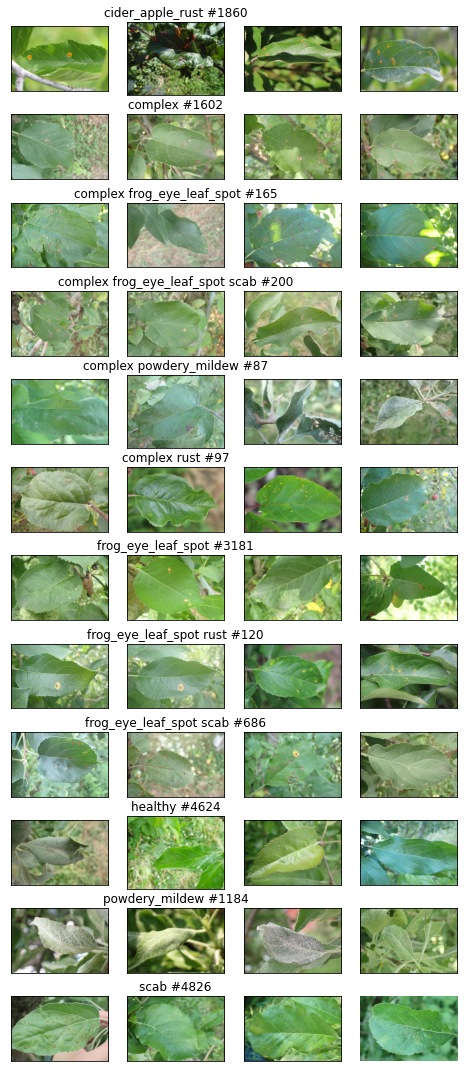

In [ ]:
import matplotlib.pyplot as plt

nb_samples = 4
n, m = len(np.unique(train_data['labels_sorted'])), nb_samples
fig, axarr = plt.subplots(nrows=n, ncols=m, figsize=(m * 2, n * 1.6))
for ilb, (lb, df_) in enumerate(train_data.groupby('labels_sorted')):
    img_names = list(df_['image'])
    for i in range(m):
        img_name = img_names[i]
        img = plt.imread(os.path.join(base_path, f"train_images/{img_name}"))
        axarr[ilb, i].imshow(img)
        if i == 1:
            axarr[ilb, i].set_title(f"{lb} #{len(df_)}")
        axarr[ilb, i].set_xticks([])
        axarr[ilb, i].set_yticks([])
plt.axis('off')

## Dataset & DataModule

Creating standard PyTorch dataset to define how the data shall be loaded and set representations.
We define the sample pair as:
 - RGB image
 - one-hot labels encoding

A DataModule standardizes the training, val, test splits, data preparation and transforms.
The main advantage is consistent data splits, data preparation and transforms across models.

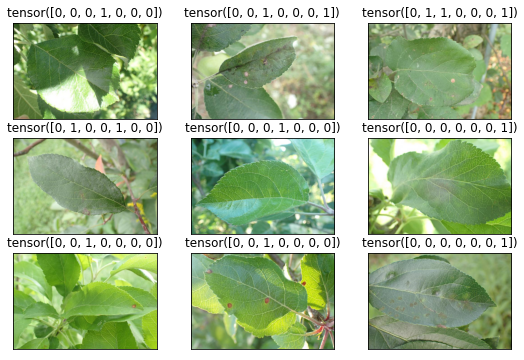

In [ ]:
import os
import torch
import pytorch_lightning as pl

from kaggle_plantpatho.data import PlantPathologyDataset

dataset = PlantPathologyDataset()

# quick view
fig = plt.figure(figsize=(9, 6))
for i in range(9):
    img, lb = dataset[i]
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(lb)

Let us add also a simplified version, where we keep only complex label for multi-label cases and the true label for all others...

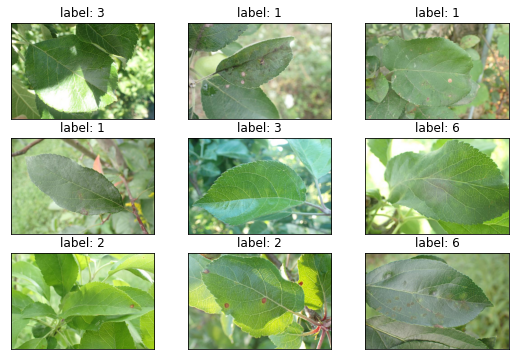

In [ ]:
from kaggle_plantpatho.data import PlantPathologySimpleDataset

dataset = PlantPathologySimpleDataset()

# quick view
fig = plt.figure(figsize=(9, 6))
for i in range(6):
    img, lb = dataset[i]
    ax = fig.add_subplot(2, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(f"label: {lb}")

The DataModule include creating training and validation dataset with given split and feading it to particular data loaders...

training dataset: 14905
validation dataset: 3727


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch labels: tensor([15, 14, 30, 32, 10,  2, 32])
image size: torch.Size([3, 224, 224])


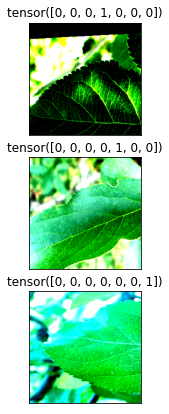

In [15]:
from kaggle_plantpatho.data import PlantPathologyDM

dm = PlantPathologyDM(simple=False, batch_size=128)
dm.setup()
print(dm.num_classes)

fig = plt.figure(figsize=(3, 7))
for imgs, lbs in dm.train_dataloader():
    print(f'batch labels: {torch.sum(lbs, axis=0)}')
    print(f'image size: {imgs[0].shape}')
    for i in range(3):
        ax = fig.add_subplot(3, 1, i + 1, xticks=[], yticks=[])
        # print(np.rollaxis(imgs[i].numpy(), 0, 3).shape)
        ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3))
        ax.set_title(lbs[i])
    break

## CNN Model

We start with some stanrd CNN models taken from torch vision.
Then we define Ligthning module including training and validation step and configure optimizer/schedular.

In [37]:
from kaggle_plantpatho.models import LitResnet, MultiPlantPathology

# see: https://pytorch.org/vision/stable/models.html
net = LitResnet(arch='resnet50', num_classes=dm.num_classes)
# print(net)
model = MultiPlantPathology(model=net)

## Training

We use Pytorch Lightning which allow us to drop all the boilet plate code and simplify all training just to use/call Trainer...

In [ ]:
logger = pl.loggers.CSVLogger(save_dir='logs/', name=model.arch)
swa = pl.callbacks.StochasticWeightAveraging(swa_epoch_start=0.6)

# ==============================

trainer = pl.Trainer(
    # fast_dev_run=True,
    gpus=1,
    callbacks=[swa],
    logger=logger,
    max_epochs=10,
    precision=16,
    accumulate_grad_batches=8,
    val_check_interval=0.25,
    progress_bar_refresh_rate=1,
    weights_summary='top',
)

# ==============================

# trainer.tune(model, datamodule=dm)
trainer.fit(model=model, datamodule=dm)

Quick visualization of the training process...

   valid_loss  valid_acc  valid_f1  epoch  step  train_loss  train_acc
0    0.721775   0.868527  0.269467      0     3         NaN        NaN
1    0.686670   0.905822  0.651019      0     7         NaN        NaN
2    0.675234   0.922918  0.728381      0    10         NaN        NaN
3    0.666416   0.939821  0.791882      0    14         NaN        NaN
4    0.660945   0.948446  0.822669      1    18         NaN        NaN


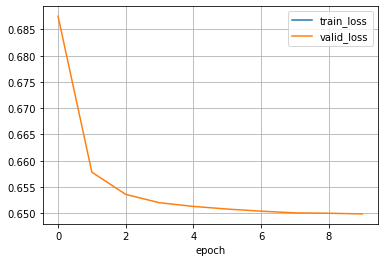

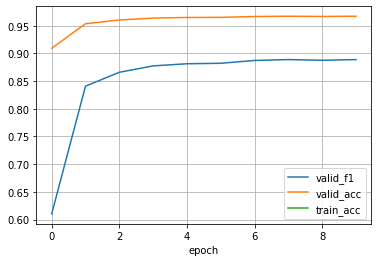

In [29]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
print(metrics.head())

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[['train_loss', 'valid_loss']].plot(grid=True, legend=True, xlabel=agg_col)
df_metrics[['valid_f1', 'valid_acc', 'train_acc']].plot(grid=True, legend=True, xlabel=agg_col)